# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Import the required libraries and dependencies
import pandas as pd
from datetime import datetime
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date', 
    parse_dates=True, 
    infer_datetime_format=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())
df_mercado_trends_original = df_mercado_trends.copy

C:\Users\Thomas\AppData\Local\Temp\ipykernel_4936\1245703844.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_trends = pd.read_csv(
C:\Users\Thomas\AppData\Local\Temp\ipykernel_4936\1245703844.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Axes: title={'center': 'May 2020'}, xlabel='Day', ylabel='Traffic'>

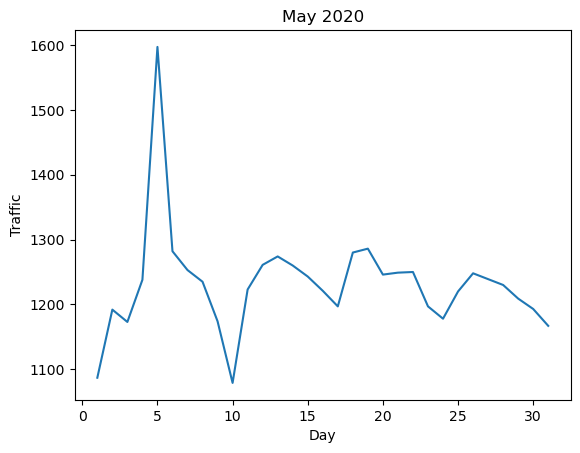

In [5]:
# Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

# Calculate the total search traffic for the month, and then compare the value to the monthly median across all months.

# Did the Google search traffic increase during the month that MercadoLibre released its financial results? Write your answer in the space provided in the starter file.

df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index)
df_mercado_trends['Date'] = df_mercado_trends.index.date
df_mercado_trends['Year'] = df_mercado_trends.index.year
df_mercado_trends['Month'] = df_mercado_trends.index.month
df_mercado_trends['Day'] = df_mercado_trends.index.day
df_mercado_trends['Hour'] = df_mercado_trends.index.hour
df_mercado_trends['Day_of_week'] = df_mercado_trends.index.day_of_week
df_mercado_trends['Week_of_year'] = df_mercado_trends.index.isocalendar().week
df_mercado_trends['Traffic'] = df_mercado_trends['Search Trends']
# Slice the DataFrame to just the month of May 2020
selected_rows = df_mercado_trends.loc[df_mercado_trends['Year'] == 2020]
selected_rows = selected_rows.loc[selected_rows['Month'] == 5]

daily_df = selected_rows.groupby(df_mercado_trends['Day']).Traffic.sum()

# Plot to visualize the data for May 2020

daily_df.plot(title='May 2020', ylabel='Traffic')


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
May_df = selected_rows.groupby(df_mercado_trends['Month']).Traffic.sum()

# View the traffic_may_2020 value
May_df

Month
5    38181
Name: Traffic, dtype: int64

In [7]:
# Calcluate the monhtly median search traffic across all months 
# Group the DataFrame by index year and then index month, chain the sum and then the median functions

Monthly_median_df = df_mercado_trends.groupby(['Year' , 'Month']).Traffic.sum().median()

# View the median_monthly_traffic value
Monthly_median_df

35172.5

In [8]:
# To compare the seach traffic for the month of May 2020 to the overall monthly median value,
# Divide the may traffic total by the median monthly traffic
#traffic_may_2020/median_monthly_traffic
overall_monthly_median = May_df / Monthly_median_df
overall_monthly_median

Month
5    1.085536
Name: Traffic, dtype: float64

##### Answer the following question: 

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** YES : 38181 / 35172.5 or 1.085

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

<Axes: title={'center': 'Average Hourly Traffic'}, xlabel='Hour', ylabel='Traffic'>

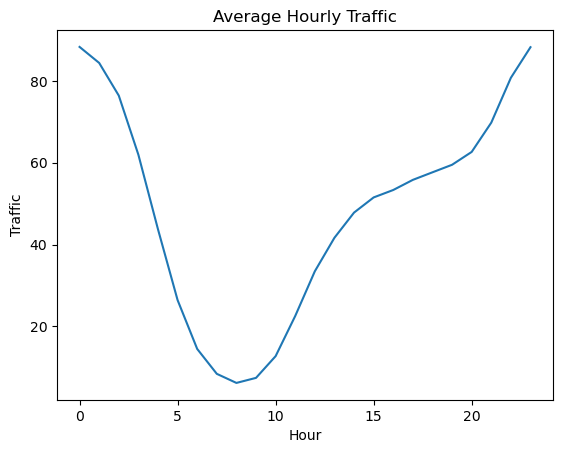

In [9]:
# Group the hourly search data to plot the average traffic by hour of the day. Does the search traffic peak a a particular time of day or is it relatively consistent? 
traffic_by_hour_of_the_day_df = df_mercado_trends.groupby(['Hour']).Traffic.mean()
traffic_by_hour_of_the_day_df.plot(title='Average Hourly Traffic', ylabel='Traffic')

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Axes: title={'center': 'Average Day Of Week Traffic'}, xlabel='Day_of_week', ylabel='Traffic'>

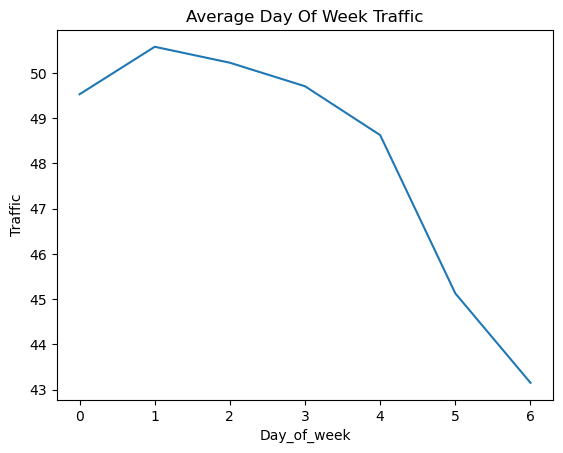

In [10]:
# Group the hourly search data to plot the average traffic by the day of week 
traffic_by_hour_and_day_of_week_df = df_mercado_trends.groupby(['Day_of_week']).Traffic.mean()
traffic_by_hour_and_day_of_week_df.plot(title='Average Day Of Week Traffic', ylabel='Traffic')


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Axes: title={'center': 'Average Week of Year Traffic'}, xlabel='Week_of_year', ylabel='Traffic'>

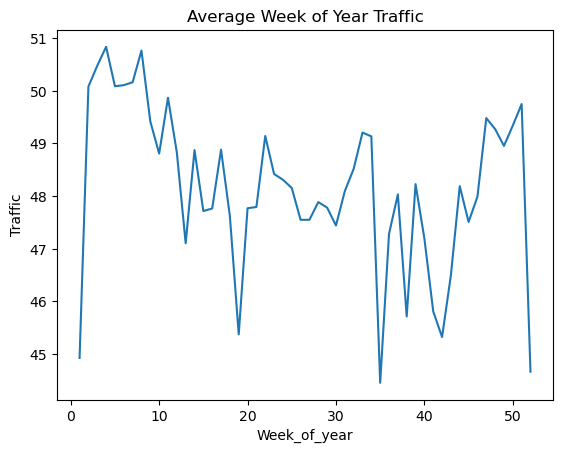

In [11]:
# Group the hourly search data to plot the average traffic by the week of the year 
traffic_by_hour_and_day_of_week_df = df_mercado_trends.groupby(['Week_of_year']).Traffic.mean()
traffic_by_hour_and_day_of_week_df.plot(title='Average Week of Year Traffic', ylabel='Traffic')

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** 

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [12]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True, 
    infer_datetime_format=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())
df_mercado_stock_original = df_mercado_stock.copy

C:\Users\Thomas\AppData\Local\Temp\ipykernel_4936\1876644456.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_stock = pd.read_csv(


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Axes: xlabel='date'>

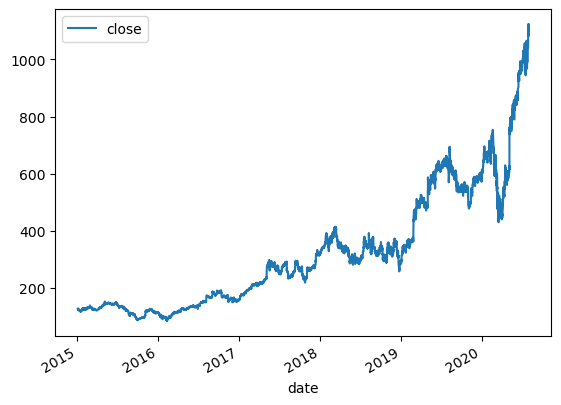

In [13]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock.plot()

In [14]:
# Get df_mercado_stock Concatenatable with df_mercado_trends

df_mercado_stock.index = pd.to_datetime(df_mercado_stock.index)
# df_mercado_stock['Date'] = df_mercado_stock.index.date
# df_mercado_stock['Year'] = df_mercado_stock.index.year
# df_mercado_stock['Month'] = df_mercado_stock.index.month
# df_mercado_stock['Day'] = df_mercado_stock.index.day
# df_mercado_stock['Hour'] = df_mercado_stock.index.hour
# df_mercado_stock['Day_of_week'] = df_mercado_stock.index.day_of_week
# df_mercado_stock['Week_of_year'] = df_mercado_stock.index.isocalendar().week
df_mercado_stock['Close'] = df_mercado_stock['close']

# View the first and last five rows of the DataFrame
df_mercado_stock



,close,Close
date,,
2015-01-02 09:00:00,127.670,127.670
2015-01-02 10:00:00,125.440,125.440
2015-01-02 11:00:00,125.570,125.570
2015-01-02 12:00:00,125.400,125.400
2015-01-02 13:00:00,125.170,125.170
...,...,...
2020-07-31 11:00:00,1105.780,1105.780
2020-07-31 12:00:00,1087.925,1087.925
2020-07-31 13:00:00,1095.800,1095.800


In [15]:
df_mercado_trends

,Search Trends,Date,Year,Month,Day,Hour,Day_of_week,Week_of_year,Traffic
Date,,,,,,,,,
2016-06-01 00:00:00,97,2016-06-01,2016,6,1,0,2,22,97
2016-06-01 01:00:00,92,2016-06-01,2016,6,1,1,2,22,92
2016-06-01 02:00:00,76,2016-06-01,2016,6,1,2,2,22,76
2016-06-01 03:00:00,60,2016-06-01,2016,6,1,3,2,22,60
2016-06-01 04:00:00,38,2016-06-01,2016,6,1,4,2,22,38
...,...,...,...,...,...,...,...,...,...
2020-09-07 20:00:00,71,2020-09-07,2020,9,7,20,0,37,71
2020-09-07 21:00:00,83,2020-09-07,2020,9,7,21,0,37,83
2020-09-07 22:00:00,96,2020-09-07,2020,9,7,22,0,37,96


In [16]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data

horizontal_stack = pd.concat([df_mercado_trends, df_mercado_stock], axis=1)
horizontal_dropna = horizontal_stack.dropna()

# View the first and last five rows of the DataFrame
horizontal_dropna

,Search Trends,Date,Year,Month,Day,Hour,Day_of_week,Week_of_year,Traffic,close,Close
2016-06-01 09:00:00,6.0,2016-06-01,2016.0,6.0,1.0,9.0,2.0,22,6.0,135.160,135.160
2016-06-01 10:00:00,12.0,2016-06-01,2016.0,6.0,1.0,10.0,2.0,22,12.0,136.630,136.630
2016-06-01 11:00:00,22.0,2016-06-01,2016.0,6.0,1.0,11.0,2.0,22,22.0,136.560,136.560
2016-06-01 12:00:00,33.0,2016-06-01,2016.0,6.0,1.0,12.0,2.0,22,33.0,136.420,136.420
2016-06-01 13:00:00,40.0,2016-06-01,2016.0,6.0,1.0,13.0,2.0,22,40.0,136.100,136.100
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 11:00:00,20.0,2020-07-31,2020.0,7.0,31.0,11.0,4.0,31,20.0,1105.780,1105.780
2020-07-31 12:00:00,32.0,2020-07-31,2020.0,7.0,31.0,12.0,4.0,31,32.0,1087.925,1087.925
2020-07-31 13:00:00,41.0,2020-07-31,2020.0,7.0,31.0,13.0,4.0,31,41.0,1095.800,1095.800
2020-07-31 14:00:00,47.0,2020-07-31,2020.0,7.0,31.0,14.0,4.0,31,47.0,1110.650,1110.650


In [17]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06) 
first_half_2020 = horizontal_dropna.loc[horizontal_dropna['Year'] == 2020]
first_half_2020 = first_half_2020.loc[first_half_2020['Month'] <= 6]

# View the first and last five rows of first_half_2020 DataFrame
first_half_2020_Close_Traffic = first_half_2020[['Close','Traffic']]
first_half_2020_Close_Traffic

,Close,Traffic
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0
...,...,...
2020-06-30 11:00:00,976.170,17.0
2020-06-30 12:00:00,977.500,27.0
2020-06-30 13:00:00,973.230,37.0
2020-06-30 14:00:00,976.500,45.0


array([<Axes: >, <Axes: >], dtype=object)

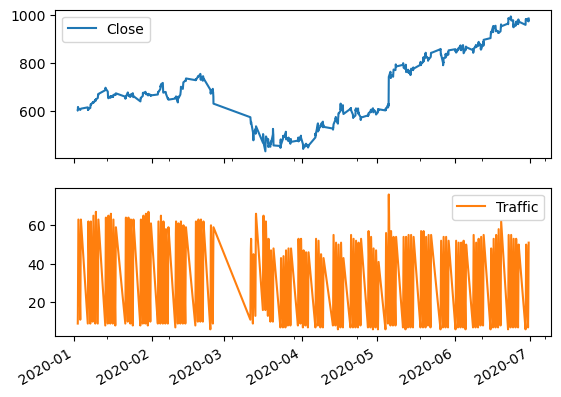

In [18]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
first_half_2020_Close_Traffic.plot(subplots=True)


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** In truth, our evidence of a common trend between search activity and stock price is pretty limited. It does appear generally however that the low point for Mercado Libre's stock price, late March to early April, did coincide with lower search activity for the firm. Search activity does pick up along with its stock price, although the stock price from mid-April onward definitively outpaces search interest.

There's one important thing to note: if you zoom in both graphs to the spike around May 5th, 2020, you'll find the date of the company's earnings release to the public. It looks like search traffic for the firm spiked about two hours before the firm's stock price spiked. This could indicate a predictable pattern (can Google Searches predict the stock price?), but an alternative explanation might just be that people tend to search for more information about the firm right before an earnings announcement gets released. We'd need to do a little more time-series research to see which explanation best fits the data.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [19]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
horizontal_dropna_Close_Traffic =  horizontal_dropna[['Close','Traffic']]
horizontal_dropna_Close_Traffic['Lagged Search Trends'] = horizontal_dropna_Close_Traffic['Traffic'].shift(1) 
horizontal_dropna_Close_Traffic


C:\Users\Thomas\AppData\Local\Temp\ipykernel_4936\1498487304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horizontal_dropna_Close_Traffic['Lagged Search Trends'] = horizontal_dropna_Close_Traffic['Traffic'].shift(1)


,Close,Traffic,Lagged Search Trends
2016-06-01 09:00:00,135.160,6.0,NaN
2016-06-01 10:00:00,136.630,12.0,6.0
2016-06-01 11:00:00,136.560,22.0,12.0
2016-06-01 12:00:00,136.420,33.0,22.0
2016-06-01 13:00:00,136.100,40.0,33.0
...,...,...,...
2020-07-31 11:00:00,1105.780,20.0,11.0
2020-07-31 12:00:00,1087.925,32.0,20.0
2020-07-31 13:00:00,1095.800,41.0,32.0
2020-07-31 14:00:00,1110.650,47.0,41.0


In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

horizontal_dropna_Close_Traffic['Stock Volatility'] = horizontal_dropna_Close_Traffic['Close'].pct_change().rolling(4).std()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_4936\279529129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horizontal_dropna_Close_Traffic['Stock Volatility'] = horizontal_dropna_Close_Traffic['Close'].pct_change().rolling(4).std()


In [21]:
# Visualize the stock volatility

horizontal_dropna_Close_Traffic

,Close,Traffic,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.160,6.0,NaN,NaN
2016-06-01 10:00:00,136.630,12.0,6.0,NaN
2016-06-01 11:00:00,136.560,22.0,12.0,NaN
2016-06-01 12:00:00,136.420,33.0,22.0,NaN
2016-06-01 13:00:00,136.100,40.0,33.0,0.006134
...,...,...,...,...
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [22]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

horizontal_dropna_Close_Traffic['Hourly Stock Return'] =  (horizontal_dropna_Close_Traffic['Close'] - horizontal_dropna_Close_Traffic['Close'].shift(1)) / horizontal_dropna_Close_Traffic['Close'].shift(1) 

C:\Users\Thomas\AppData\Local\Temp\ipykernel_4936\1129089845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horizontal_dropna_Close_Traffic['Hourly Stock Return'] =  (horizontal_dropna_Close_Traffic['Close'] - horizontal_dropna_Close_Traffic['Close'].shift(1)) / horizontal_dropna_Close_Traffic['Close'].shift(1)


In [23]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame

horizontal_dropna_Close_Traffic

,Close,Traffic,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.160,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.630,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.560,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.420,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.100,40.0,33.0,0.006134,-0.002346
...,...,...,...,...,...
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [24]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
horizontal_dropna_Correlation = horizontal_dropna_Close_Traffic [['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']]
corr = horizontal_dropna_Correlation.corr()
corr

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** If we read down the second column (or read along the second row), we see that there's a slight negative correlation between searches for the firm and its subsequent stock volatility. More searches (slightly) tend to indicate less near-term hourly stock risk for the firm.

On the other hand, there's a positive correlation between search activity in one hour and stock returns in the next: as search activity goes up, so will the firm's stock price in the short term. This effect is very weak though, only half the size of the effect on stock volatility. With the correlation so close to zero, some might also say that there's almost no relationship between these two variables whatsoever, and that the small findings that we do have could be just due to chance. While there's no required threshold when looking at correlation between stock returns and the variables used to predict them, it does tend to be that correlations in this context tend to be very low across the board. It's hard to predict the market!

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [25]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index


# Label the columns ds and y so that the syntax is recognized by Prophet


# Drop an NaN values from the prophet_df DataFrame


# View the first and last five rows of the mercado_prophet_df DataFrame


In [26]:
# Call the Prophet function, store as an object


In [27]:
# Fit the time-series model.


In [28]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)


# View the last five rows of the future_mercado_trends DataFrame


In [29]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame


# Display the first five rows of the forecast_mercado_trends DataFrame


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

In [30]:
# Plot the Prophet predictions for the Mercado trends data


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** 


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [31]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column


# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame



Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

In [32]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours 


In [33]:
# Reset the index in the forecast_mercado_trends DataFrame


# Use the plot_components function to visualize the forecast results 
# for the forecast_canada DataFrame 


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** 

**Question:** Which day of week gets the most search traffic? 
   
**Answer:** 

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** 
